In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
'''for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))'''

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"for dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))"

# **Importing all necessary modules**

In [2]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from functools import partial
from skimage import io, transform
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from torchvision import models

# Creating custom data loader
Here, I create a custom data loader class NucleiDataset, which takes the csv_path, root directory and transoform function and loads the dataset as I customized, for transformer, I created a custom ToTensor class which will convert the image to tensor (I refered to Lab 5A for this).

In [3]:
class ToTensor(object):
    def __call__(self, sample):
        image = sample['image']
        # swap color axis because numpy image: H x W x C, torch image: C x H x W
        image = image.transpose((2, 0, 1))
        sample['image'] = torch.from_numpy(image)
        return sample
    
class NucleiDataset(Dataset):
    def __init__(self, csv_path, root_dir, transform=None):
        self.csv_path = csv_path
        self.data = pd.read_csv(csv_path,delimiter=',')
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        image = io.imread(img_name)
        label = self.data.iloc[idx, 1]
        sample = {'image': image, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

transform = transforms.Compose([
    ToTensor()
])

dataset = NucleiDataset(csv_path='/kaggle/input/deep-learning-for-msc-2022-23/train.csv', root_dir='/kaggle/input/deep-learning-for-msc-2022-23/train', transform=transform)


Now, after loading the dataset, I split it into training and validation using random_split.

In [4]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Use random_split to split the dataset into train and validation sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Defining the first model 
Below, I have created Model 1 for the project, where I didn't use any pre-trained models and created my own model. I refered to Lab 3 for this.
After creating the model, I wrote the training function.

The *config* parameter will receive the hyperparameters that I used to train the model with (learning rate and batch size). The *checkpoint_dir* parameter is used to restore checkpoints. The *root_dir* specifies the directory where we load and store the data, so multiple runs can share the same data source.

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 25 * 25, 120)
        self.fc2 = nn.Linear(120, 4)
        self.output = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 32 * 25 * 25)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.output(x)
        return x

def train_model1(config, checkpoint_dir=None, root_dir=None):
    # Set up the model
    model = Net()
    # Set up the device
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:            
            model = nn.DataParallel(model)
        model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=config["lr"], momentum=0.9)
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=2)
    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        model.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)
    for epoch in range(10):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data['image'].float(), data['label']
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                running_loss / epoch_steps))
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(val_loader, 0):
            with torch.no_grad():
                inputs, labels = data['image'].float(), data['label']
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((model.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=(val_loss / val_steps), accuracy=correct / total)
    print("Finished Training")

# Defining the main function
Below I have defined the main function, in which I first created the config dictionary containing hyperparameters for experimentation, and then I created the scheduler, reporter and result. I stored the best trial in best_trail and returned it's value. 
After running this, I will obtain the parameters that give the highest accuracy for my custom model.

In [6]:
def main(num_samples=10, max_num_epochs=10, gpus_per_trial=2):
    config = {
        "lr": tune.loguniform(1e-4, 2e-4),
        "batch_size": tune.choice([16, 32]),
    }
    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)
    reporter = CLIReporter(
        parameter_columns=["lr", "batch_size"], 
        metric_columns=["loss", "accuracy", "training_iteration"])
    result = tune.run(
        partial(train_model1, root_dir='/kaggle/input/deep-learning-for-msc-2022-23/train'),
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter)

    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(
        best_trial.last_result["loss"]))
    print("Best trial final validation accuracy: {}".format(
        best_trial.last_result["accuracy"]))
    return best_trial

bt = main(num_samples=10, max_num_epochs=10, gpus_per_trial=2)

2023-03-27 08:40:53,714	INFO worker.py:1535 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
/opt/conda/lib/python3.7/site-packages/ray/tune/trainable/function_trainable.py:612: DeprecationWarning: `checkpoint_dir` in `func(config, checkpoint_dir)` is being deprecated. To save and load checkpoint in trainable functions, please use the `ray.air.session` API:

from ray.air import session

def train(config):
    # ...
    session.report({"metric": metric}, checkpoint=checkpoint)

For more information please see https://docs.ray.io/en/master/tune/api_docs/trainable.html

  DeprecationWarning,
E0327 08:40:57.065414207  188040 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:40:57 (running for 00:00:00.38)
Memory usage on this node: 2.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model1_2023-03-27_08-40-57
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+--------------------------+----------+-------------------+-------------+--------------+
| Trial name               | status   | loc               |          lr |   batch_size |
|--------------------------+----------+-------------------+-------------+--------------|
| train_model1_17d30_00000 | RUNNING  | 172.19.2.2:188311 | 0.00010936  |           16 |
| train_model1_17d30_00001 | PENDING  |                   | 0.00012774  |           32 |
| train_model1_17d30_00002 | PENDING  |                   | 0.000188502 |           16 |
| tra

(func pid=188311) E0327 08:41:05.855739152  188355 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:41:08 (running for 00:00:11.76)
Memory usage on this node: 4.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model1_2023-03-27_08-40-57
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+--------------------------+----------+-------------------+-------------+--------------+
| Trial name               | status   | loc               |          lr |   batch_size |
|--------------------------+----------+-------------------+-------------+--------------|
| train_model1_17d30_00000 | RUNNING  | 172.19.2.2:188311 | 0.00010936  |           16 |
| train_model1_17d30_00001 | PENDING  |                   | 0.00012774  |           32 |
| train_model1_17d30_00002 | PENDING  |                   | 0.000188502 |           16 |
| tra

Trial name,accuracy,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,loss,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_model1_17d30_00000,0.791667,2023-03-27_08-43-24,True,,0553c2101fbe4f9e8a4b7e1ce8ab6c68,ea0567bcd13b,10,0.589207,172.19.2.2,188311,True,140.083,12.6037,140.083,1679906604,0,,10,17d30_00000,0.00686693
train_model1_17d30_00001,0.832011,2023-03-27_08-44-00,True,,d2d80a37956941e58147caf536c4822e,ea0567bcd13b,2,0.457871,172.19.2.2,198398,True,30.7661,11.2547,30.7661,1679906640,0,,2,17d30_00001,0.00846934
train_model1_17d30_00002,0.718254,2023-03-27_08-44-27,True,,0f651a2906f44a51b1747ed6c6db2327,ea0567bcd13b,1,0.797097,172.19.2.2,199518,True,20.7523,20.7523,20.7523,1679906667,0,,1,17d30_00002,0.0084579
train_model1_17d30_00003,0.778439,2023-03-27_08-45-08,True,,c11fe52ebdbe4682be57ba29ed6af1f2,ea0567bcd13b,2,0.584826,172.19.2.2,200573,True,34.4279,12.9341,34.4279,1679906708,0,,2,17d30_00003,0.00527
train_model1_17d30_00004,0.595238,2023-03-27_08-45-35,True,,e021e056034e48979c02d13aa3847292,ea0567bcd13b,1,1.12244,172.19.2.2,202644,True,20.1313,20.1313,20.1313,1679906735,0,,1,17d30_00004,0.00599456
train_model1_17d30_00005,0.464947,2023-03-27_08-46-02,True,,caceee7a1d0e4df3bd92c4243fab54c6,ea0567bcd13b,1,1.18756,172.19.2.2,203700,True,20.929,20.929,20.929,1679906762,0,,1,17d30_00005,0.00748897
train_model1_17d30_00006,0.509259,2023-03-27_08-46-27,True,,3a298d2a04a84577838f4b1f6b473fa5,ea0567bcd13b,1,1.13514,172.19.2.2,204757,True,19.2659,19.2659,19.2659,1679906787,0,,1,17d30_00006,0.00494909
train_model1_17d30_00007,0.628307,2023-03-27_08-46-55,True,,4093d70ea8864140bc2a8132cb21173d,ea0567bcd13b,1,0.956442,172.19.2.2,205339,True,21.1564,21.1564,21.1564,1679906815,0,,1,17d30_00007,0.0067997
train_model1_17d30_00008,0.467593,2023-03-27_08-47-21,True,,44f88022b9404e2dac6be98a4daab89d,ea0567bcd13b,1,1.16016,172.19.2.2,206396,True,19.5915,19.5915,19.5915,1679906841,0,,1,17d30_00008,0.010848
train_model1_17d30_00009,0.796296,2023-03-27_08-47-58,True,,7fbda67eb61c4ddab44a32e47d1d1e96,ea0567bcd13b,2,0.524274,172.19.2.2,206981,True,30.8172,12.31,30.8172,1679906878,0,,2,17d30_00009,0.00646496


== Status ==
Current time: 2023-03-27 08:41:30 (running for 00:00:33.70)
Memory usage on this node: 5.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: -0.562827119701787
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model1_2023-03-27_08-40-57
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+--------------------------+----------+-------------------+-------------+--------------+----------+------------+----------------------+
| Trial name               | status   | loc               |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|--------------------------+----------+-------------------+-------------+--------------+----------+------------+----------------------|
| train_model1_17d30_00000 | RUNNING  | 172.19.2.2:188311 | 0.00010936  |           16 | 0.562827 |   0.765212 |     

(func pid=188311) E0327 08:42:02.637424820  188355 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:42:10 (running for 00:01:13.60)
Memory usage on this node: 5.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: -0.38995345956400823 | Iter 2.000: -0.4439640631801204 | Iter 1.000: -0.562827119701787
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model1_2023-03-27_08-40-57
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+--------------------------+----------+-------------------+-------------+--------------+----------+------------+----------------------+
| Trial name               | status   | loc               |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|--------------------------+----------+-------------------+-------------+--------------+----------+------------+----------------------|
| train_model1_17d30_00000 | RUNNING  | 172.19.2.2:188311 | 0.00010936  |           16

(func pid=188311) E0327 08:42:55.596687449  188355 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=188311) E0327 08:42:55.648563745  188355 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=188311) E0327 08:42:58.093797854  188355 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:43:03 (running for 00:02:05.84)
Memory usage on this node: 5.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: -0.437196119012017 | Iter 4.000: -0.38995345956400823 | Iter 2.000: -0.4439640631801204 | Iter 1.000: -0.562827119701787
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model1_2023-03-27_08-40-57
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+--------------------------+----------+-------------------+-------------+--------------+----------+------------+----------------------+
| Trial name               | status   | loc               |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|--------------------------+----------+-------------------+-------------+--------------+----------+------------+----------------------|
| train_model1_17d30_00000 | RUNNING  | 172.19.2.2:188311 | 0.00010936  

(func pid=198398) E0327 08:43:31.899327647  198439 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:43:35 (running for 00:02:37.80)
Memory usage on this node: 4.8/15.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 8.000: -0.437196119012017 | Iter 4.000: -0.38995345956400823 | Iter 2.000: -0.4439640631801204 | Iter 1.000: -0.562827119701787
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model1_2023-03-27_08-40-57
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+--------------------------+------------+-------------------+-------------+--------------+----------+------------+----------------------+
| Trial name               | status     | loc               |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-------------------+-------------+--------------+----------+------------+----------------------|
| train_model1_17d30_00001 | RUNNING    | 172.19.2.2

(func pid=199518) E0327 08:44:08.567028022  199553 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:44:11 (running for 00:03:14.46)
Memory usage on this node: 4.4/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 8.000: -0.437196119012017 | Iter 4.000: -0.38995345956400823 | Iter 2.000: -0.4509174784906862 | Iter 1.000: -0.5559010807294071
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model1_2023-03-27_08-40-57
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+--------------------------+------------+-------------------+-------------+--------------+----------+------------+----------------------+
| Trial name               | status     | loc               |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-------------------+-------------+--------------+----------+------------+----------------------|
| train_model1_17d30_00002 | RUNNING    | 172.19.2.

(func pid=200573) E0327 08:44:35.990077189  200614 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:44:39 (running for 00:03:41.91)
Memory usage on this node: 4.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: -0.437196119012017 | Iter 4.000: -0.38995345956400823 | Iter 2.000: -0.4509174784906862 | Iter 1.000: -0.562827119701787
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model1_2023-03-27_08-40-57
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+--------------------------+------------+-------------------+-------------+--------------+----------+------------+----------------------+
| Trial name               | status     | loc               |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-------------------+-------------+--------------+----------+------------+----------------------|
| train_model1_17d30_00003 | RUNNING    | 172.19.2.2

(func pid=202644) E0327 08:45:17.276634378  202679 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:45:20 (running for 00:04:22.97)
Memory usage on this node: 4.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 8.000: -0.437196119012017 | Iter 4.000: -0.38995345956400823 | Iter 2.000: -0.45787089380125207 | Iter 1.000: -0.5559010807294071
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model1_2023-03-27_08-40-57
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+--------------------------+------------+-------------------+-------------+--------------+----------+------------+----------------------+
| Trial name               | status     | loc               |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-------------------+-------------+--------------+----------+------------+----------------------|
| train_model1_17d30_00004 | RUNNING    | 172.19.2

(func pid=203700) E0327 08:45:43.715189767  203740 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:45:46 (running for 00:04:49.68)
Memory usage on this node: 4.5/15.6 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 8.000: -0.437196119012017 | Iter 4.000: -0.38995345956400823 | Iter 2.000: -0.45787089380125207 | Iter 1.000: -0.562827119701787
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model1_2023-03-27_08-40-57
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+--------------------------+------------+-------------------+-------------+--------------+----------+------------+----------------------+
| Trial name               | status     | loc               |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-------------------+-------------+--------------+----------+------------+----------------------|
| train_model1_17d30_00005 | RUNNING    | 172.19.2.

(func pid=203700) E0327 08:46:00.265746172  203740 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:46:01 (running for 00:05:04.72)
Memory usage on this node: 5.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 8.000: -0.437196119012017 | Iter 4.000: -0.38995345956400823 | Iter 2.000: -0.45787089380125207 | Iter 1.000: -0.562827119701787
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model1_2023-03-27_08-40-57
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+--------------------------+------------+-------------------+-------------+--------------+----------+------------+----------------------+
| Trial name               | status     | loc               |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-------------------+-------------+--------------+----------+------------+----------------------|
| train_model1_17d30_00005 | RUNNING    | 172.19.2.

(func pid=204757) E0327 08:46:10.723467223  204791 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:46:13 (running for 00:05:16.50)
Memory usage on this node: 4.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 8.000: -0.437196119012017 | Iter 4.000: -0.38995345956400823 | Iter 2.000: -0.45787089380125207 | Iter 1.000: -0.6799620676981775
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model1_2023-03-27_08-40-57
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+--------------------------+------------+-------------------+-------------+--------------+----------+------------+----------------------+
| Trial name               | status     | loc               |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-------------------+-------------+--------------+----------+------------+----------------------|
| train_model1_17d30_00006 | RUNNING    | 172.19.2

(func pid=205339) E0327 08:46:35.947273688  205381 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:46:39 (running for 00:05:41.87)
Memory usage on this node: 4.8/15.6 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 8.000: -0.437196119012017 | Iter 4.000: -0.38995345956400823 | Iter 2.000: -0.45787089380125207 | Iter 1.000: -0.797097015694568
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model1_2023-03-27_08-40-57
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+--------------------------+------------+-------------------+-------------+--------------+----------+------------+----------------------+
| Trial name               | status     | loc               |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-------------------+-------------+--------------+----------+------------+----------------------|
| train_model1_17d30_00007 | RUNNING    | 172.19.2.

(func pid=205339) E0327 08:46:52.460806272  205381 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:46:54 (running for 00:05:56.92)
Memory usage on this node: 5.8/15.6 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 8.000: -0.437196119012017 | Iter 4.000: -0.38995345956400823 | Iter 2.000: -0.45787089380125207 | Iter 1.000: -0.797097015694568
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model1_2023-03-27_08-40-57
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+--------------------------+------------+-------------------+-------------+--------------+----------+------------+----------------------+
| Trial name               | status     | loc               |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-------------------+-------------+--------------+----------+------------+----------------------|
| train_model1_17d30_00007 | RUNNING    | 172.19.2.

(func pid=206396) E0327 08:47:03.675440851  206432 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:47:06 (running for 00:06:09.58)
Memory usage on this node: 4.6/15.6 GiB 
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 8.000: -0.437196119012017 | Iter 4.000: -0.38995345956400823 | Iter 2.000: -0.45787089380125207 | Iter 1.000: -0.8767697480164076
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model1_2023-03-27_08-40-57
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+--------------------------+------------+-------------------+-------------+--------------+----------+------------+----------------------+
| Trial name               | status     | loc               |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-------------------+-------------+--------------+----------+------------+----------------------|
| train_model1_17d30_00008 | RUNNING    | 172.19.2

(func pid=206396) E0327 08:47:18.388163649  206432 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:47:22 (running for 00:06:25.04)
Memory usage on this node: 2.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 8.000: -0.437196119012017 | Iter 4.000: -0.38995345956400823 | Iter 2.000: -0.45787089380125207 | Iter 1.000: -0.9564424803382472
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model1_2023-03-27_08-40-57
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+--------------------------+------------+-------------------+-------------+--------------+----------+------------+----------------------+
| Trial name               | status     | loc               |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-------------------+-------------+--------------+----------+------------+----------------------|
| train_model1_17d30_00009 | RUNNING    | 172.19.2.2:206981 |

(func pid=206981) E0327 08:47:29.827070073  207021 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:47:32 (running for 00:06:35.72)
Memory usage on this node: 4.8/15.6 GiB 
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 8.000: -0.437196119012017 | Iter 4.000: -0.38995345956400823 | Iter 2.000: -0.45787089380125207 | Iter 1.000: -0.9564424803382472
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model1_2023-03-27_08-40-57
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+--------------------------+------------+-------------------+-------------+--------------+----------+------------+----------------------+
| Trial name               | status     | loc               |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-------------------+-------------+--------------+----------+------------+----------------------|
| train_model1_17d30_00009 | RUNNING    | 172.19.2.2:206981 |

(func pid=206981) E0327 08:47:44.036030648  207021 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=206981) E0327 08:47:46.432353697  207021 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:47:51 (running for 00:06:54.23)
Memory usage on this node: 5.8/15.6 GiB 
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 8.000: -0.437196119012017 | Iter 4.000: -0.38995345956400823 | Iter 2.000: -0.45787089380125207 | Iter 1.000: -0.8767697480164076
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model1_2023-03-27_08-40-57
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+--------------------------+------------+-------------------+-------------+--------------+----------+------------+----------------------+
| Trial name               | status     | loc               |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-------------------+-------------+--------------+----------+------------+----------------------|
| train_model1_17d30_00009 | RUNNING    | 172.19.2.2:206981 |

(func pid=206981) E0327 08:47:56.393175076  207021 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:47:56 (running for 00:06:59.26)
Memory usage on this node: 5.8/15.6 GiB 
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 8.000: -0.437196119012017 | Iter 4.000: -0.38995345956400823 | Iter 2.000: -0.45787089380125207 | Iter 1.000: -0.8767697480164076
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model1_2023-03-27_08-40-57
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+--------------------------+------------+-------------------+-------------+--------------+----------+------------+----------------------+
| Trial name               | status     | loc               |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-------------------+-------------+--------------+----------+------------+----------------------|
| train_model1_17d30_00009 | RUNNING    | 172.19.2.2:206981 |

2023-03-27 08:47:58,862	INFO tune.py:763 -- Total run time: 421.84 seconds (421.54 seconds for the tuning loop).


== Status ==
Current time: 2023-03-27 08:47:58 (running for 00:07:01.55)
Memory usage on this node: 5.8/15.6 GiB 
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 8.000: -0.437196119012017 | Iter 4.000: -0.38995345956400823 | Iter 2.000: -0.4910725373774767 | Iter 1.000: -0.8767697480164076
Resources requested: 0/2 CPUs, 0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model1_2023-03-27_08-40-57
Number of trials: 10/10 (10 TERMINATED)
+--------------------------+------------+-------------------+-------------+--------------+----------+------------+----------------------+
| Trial name               | status     | loc               |          lr |   batch_size |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-------------------+-------------+--------------+----------+------------+----------------------|
| train_model1_17d30_00000 | TERMINATED | 172.19.2.2:188311 | 0.00010936  |

# Calculating Accuracy and Loss on best obtained parameters
Using the best obtained parameters, now I will calculate accuracy and loss for every epoch on both training and validation sets.

In [7]:
model = Net()
    # Set up the device
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
    if torch.cuda.device_count() > 1:            
        model = nn.DataParallel(model)
    model.to(device)
criterion = nn.CrossEntropyLoss()
    
# USING THE BEST OBTAINED PARAMETERS FOR GETTING LOSS AND ACCURACY VALUES AS LIST TO VISUALIZE DATA.

optimizer = optim.SGD(model.parameters(), lr=bt.config["lr"], momentum=0.9)
trainLoader = DataLoader(train_dataset, batch_size=bt.config['batch_size'], shuffle=False, num_workers=2)
valLoader = DataLoader(val_dataset, batch_size=bt.config['batch_size'], shuffle=False, num_workers=2)
    
trainLoss = []
valLoss = []
trainAcc = []
valAcc = []
    
    
for epoch in range(10):
    for i,data in enumerate(trainLoader):
        train_loss = 0.0
        train_correct = 0.0
        count1 = 0
        
        inputs, labels = data['image'].float(), data['label']
        inputs, labels = inputs.to(device), labels.to(device)
        
        # forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        # backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        train_correct += torch.sum(preds == labels.data)
        count1 += inputs.size(0)
    
    # Compute the training loss and accuracy for this epoch
    loss = train_loss / count1
    acc = train_correct / count1

    # Append the loss and accuracy to the lists for plotting later
    trainLoss.append(loss)
    trainAcc.append(acc)

    # Initialize variables to compute validation loss and accuracy
    val_loss = 0.0
    val_correct = 0.0
    count2 = 0

    # Loop over your validation dataset in batches
    for i,data in enumerate(valLoader):
        # Forward pass
        inputs, labels = data['image'].float(), data['label']
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Compute the running loss and accuracy
        val_loss += loss.item() * inputs.size(0)
        val_correct += torch.sum(preds == labels.data)
        count2 += inputs.size(0)

    # Compute the validation loss and accuracy for this epoch
    loss = val_loss / count2
    acc = val_correct / count2

    # Append the loss and accuracy to the lists for plotting later
    valLoss.append(loss)
    valAcc.append(acc)


print(trainLoss)
print(trainAcc)
print(valLoss)
print(valAcc)

E0327 08:48:01.207199256  188040 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 08:48:01.251083696  188040 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 08:48:15.753291874  188040 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 08:48:15.814925132  188040 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 08:48:18.062460069  188040 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 08:48:18.123546137  188040 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 08:48:27.694140701  188040 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 08:48:27.754697081  188040 fork_posix.cc:76]           Other th

[0.9694144129753113, 0.6676284074783325, 0.5203117728233337, 0.44209036231040955, 0.4146943986415863, 0.3949877917766571, 0.4425423741340637, 0.4496835768222809, 0.3965373933315277, 0.36688923835754395]
[tensor(0.6562, device='cuda:0'), tensor(0.6875, device='cuda:0'), tensor(0.7812, device='cuda:0'), tensor(0.8125, device='cuda:0'), tensor(0.8125, device='cuda:0'), tensor(0.8438, device='cuda:0'), tensor(0.8125, device='cuda:0'), tensor(0.8438, device='cuda:0'), tensor(0.8125, device='cuda:0'), tensor(0.8125, device='cuda:0')]
[1.0377384127763214, 0.7801332115811646, 0.674180148455201, 0.590658696713271, 0.574576513161735, 0.575829943967244, 0.6315947758457648, 0.668602326559642, 0.5938711932727269, 0.5487588726023518]
[tensor(0.6746, device='cuda:0'), tensor(0.6944, device='cuda:0'), tensor(0.7487, device='cuda:0'), tensor(0.7731, device='cuda:0'), tensor(0.7817, device='cuda:0'), tensor(0.7831, device='cuda:0'), tensor(0.7725, device='cuda:0'), tensor(0.7520, device='cuda:0'), tenso

# Plotting Loss and Accuracy Graphs for Training and Validation

In this section, using *matplotlib*, I will plot graphs for training and validation sets in regards of accuracy and loss for each epoch with best parameters obtained above.

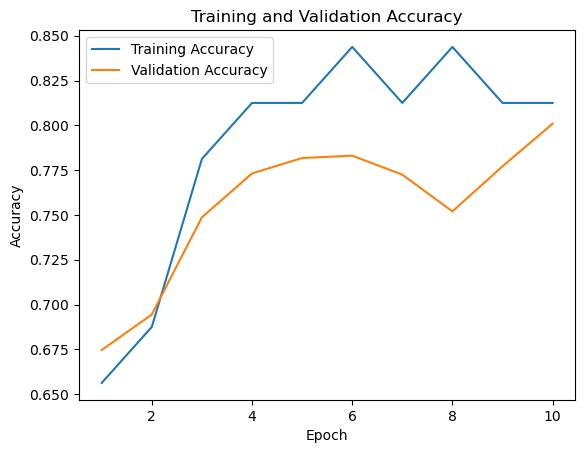

In [8]:
x = np.arange(1, 11)
train_acc_np = torch.stack(trainAcc).cpu().tolist()
valid_acc_np = torch.stack(valAcc,dim=0).cpu().tolist()

plt.plot(x, train_acc_np, label='Training Accuracy')
plt.plot(x, valid_acc_np, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

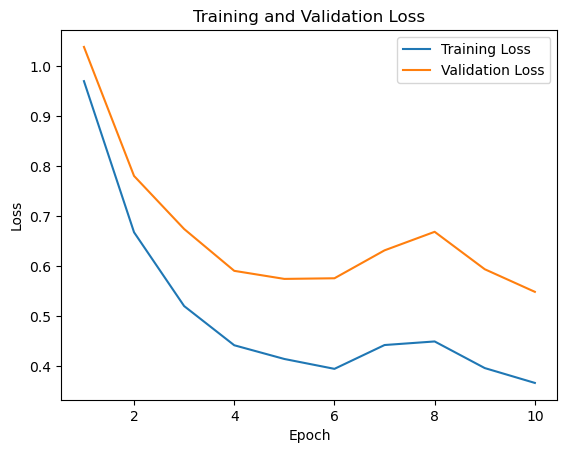

In [9]:
plt.plot(x, trainLoss, label='Training Loss')
plt.plot(x, valLoss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Confusion Matrix
To get a better view of the predicted labels against true labels, I will plot confusion matrix in this section.

In [10]:
# Confusion Matrix
predictions = []
label = []

with torch.no_grad():
    for data in valLoader:
        inputs, labels = data['image'].float(), data['label']
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, prediction = torch.max(outputs, 1)
        predictions.extend(prediction.cpu().numpy())
        label.extend(labels.cpu().numpy())

confusion_matrix1 = confusion_matrix(label,predictions)

E0327 08:50:02.912908801  188040 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 08:50:02.979748807  188040 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


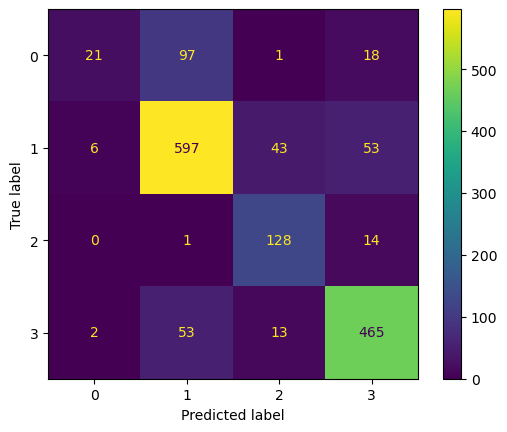

In [11]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix1).plot()

In [36]:
!pip install captum
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from captum.attr import LayerActivation

E0327 10:28:57.933874486  188040 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


# Predicting on Test data using model 1
Using model 1, now we will make predictions on test data and store the results in */kaggle/working/model1.csv* with image name and predicted labels.

In [14]:
class NucleiTestDataset(Dataset):
    def __init__(self, img_dir, transform):
        self.img_dir = img_dir
        self.image_files = sorted(os.listdir(img_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        image_path = os.path.join(self.img_dir, self.image_files[index])
        image = io.imread(image_path)
        filename = self.image_files[index]
        sample = {'image': image, 'Filename': filename}
        if self.transform:
            sample = self.transform(sample)
        return sample
    
transform = transforms.Compose([
    ToTensor()
])

In [15]:
test_dataset = NucleiTestDataset(img_dir='/kaggle/input/deep-learning-for-msc-2022-23/test',transform=transform)
# Create data loaders for the test set
testLoader = DataLoader(test_dataset, batch_size=bt.config['batch_size'],shuffle=False, num_workers=2)

In [16]:
preds = []
image = []
for data in testLoader:
    inputs = data['image'].float().to(device)
    image.extend(data['Filename'])
    # get the model predictions
    with torch.no_grad():
        outputs = model(inputs)
        
    _, predicted = torch.max(outputs, dim=1)
    
    # append the predicted labels to the list
    preds.extend(predicted.cpu().numpy().tolist())
    
data = {"Filename": image, "Label": preds}
df = pd.DataFrame(data)
df.to_csv("/kaggle/working/model1.csv",  index=False)

E0327 08:50:17.279579259  188040 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 08:50:17.344351437  188040 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


# MODEL 2

I chose ResNet34 as my pre-trained model, since it has good accuracy results and it is known to produce efficient results.

In [18]:
class ResNetClassifier(nn.Module):
    def __init__(self,num_classes = 4):
        super(ResNetClassifier, self).__init__()
        self.backbone = models.resnet34(pretrained=True)
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = self.backbone(x)
        return x
    
#resnetmodel = ResNetClassifier()

In [19]:
def train_model2(config, checkpoint_dir=None, root_dir=None):
    # Set up the model
    resnetmodel = ResNetClassifier()
    # Set up the device
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:            
            resnetmodel = nn.DataParallel(resnetmodel)
        resnetmodel.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(resnetmodel.parameters(), lr=config["lr"],weight_decay=config["weight_decay"], momentum=0.9)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        model.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)
    for epoch in range(10):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data['image'].float(), data['label']
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = resnetmodel(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                running_loss / epoch_steps))
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(val_loader, 0):
            with torch.no_grad():
                inputs, labels = data['image'].float(), data['label']
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = resnetmodel(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((model.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=(val_loss / val_steps), accuracy=correct / total)
    print("Finished Training")

In [20]:
def main(num_samples=10, max_num_epochs=10, gpus_per_trial=2):
    config = {
        "lr": tune.loguniform(1e-4, 4e-5),
        "weight_decay": tune.loguniform(1e-4, 6e-5),
    }
    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)
    reporter = CLIReporter(
        parameter_columns=["lr", "weight_decay"], 
        metric_columns=["loss", "accuracy", "training_iteration"])
    result = tune.run(
        partial(train_model2, root_dir='/kaggle/input/deep-learning-for-msc-2022-23/train'),
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter)

    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(
        best_trial.last_result["loss"]))
    print("Best trial final validation accuracy: {}".format(
        best_trial.last_result["accuracy"]))
    return best_trial

bt2 = main(num_samples=10, max_num_epochs=10, gpus_per_trial=2)

== Status ==
Current time: 2023-03-27 08:50:26 (running for 00:00:01.15)
Memory usage on this node: 5.6/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model2_2023-03-27_08-50-25
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+--------------------------+----------+-------------------+-------------+----------------+
| Trial name               | status   | loc               |          lr |   weight_decay |
|--------------------------+----------+-------------------+-------------+----------------|
| train_model2_6a760_00000 | RUNNING  | 172.19.2.2:213606 | 4.31918e-05 |    9.85294e-05 |
| train_model2_6a760_00001 | PENDING  |                   | 6.50759e-05 |    9.07168e-05 |
| train_model2_6a760_00002 | PENDING  |                   | 9.3443e-05  |    6.53272

(func pid=213606) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=213606)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=213606) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=213606)   warnings.warn(msg)
(func pid=213606) E0327 08:50:34.634550532  213642 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:50:38 (running for 00:00:13.71)
Memory usage on this node: 8.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model2_2023-03-27_08-50-25
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+--------------------------+----------+-------------------+-------------+----------------+
| Trial name               | status   | loc               |          lr |   weight_decay |
|--------------------------+----------+-------------------+-------------+----------------|
| train_model2_6a760_00000 | RUNNING  | 172.19.2.2:213606 | 4.31918e-05 |    9.85294e-05 |
| train_model2_6a760_00001 | PENDING  |                   | 6.50759e-05 |    9.07168e-05 |
| train_model2_6a760_00002 | PENDING  |                   | 9.3443e-05  |    6.53272

(func pid=213606) E0327 08:51:01.375386037  213642 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=213606) E0327 08:51:01.505067789  213642 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:51:04 (running for 00:00:38.76)
Memory usage on this node: 9.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model2_2023-03-27_08-50-25
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+--------------------------+----------+-------------------+-------------+----------------+
| Trial name               | status   | loc               |          lr |   weight_decay |
|--------------------------+----------+-------------------+-------------+----------------|
| train_model2_6a760_00000 | RUNNING  | 172.19.2.2:213606 | 4.31918e-05 |    9.85294e-05 |
| train_model2_6a760_00001 | PENDING  |                   | 6.50759e-05 |    9.07168e-05 |
| train_model2_6a760_00002 | PENDING  |                   | 9.3443e-05  |    6.53272

Trial name,accuracy,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,loss,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_model2_6a760_00000,0.859788,2023-03-27_08-54-40,True,,2d13b055c0cd4335af1a36afb9cfe738,ea0567bcd13b,10,0.376053,172.19.2.2,213606,True,246.706,23.5465,246.706,1679907280,0,,10,6a760_00000,0.00464559
train_model2_6a760_00001,0.878968,2023-03-27_08-58-57,True,,80e3d99530dd40069ccb7bb1b871d5b7,ea0567bcd13b,10,0.350692,172.19.2.2,219027,True,248.809,24.3381,248.809,1679907537,0,,10,6a760_00001,0.00585151
train_model2_6a760_00002,0.888889,2023-03-27_09-03-16,True,,e4b8cb7409844fe28151f67e2b5a0470,ea0567bcd13b,10,0.311709,172.19.2.2,224448,True,250.269,24.3336,250.269,1679907796,0,,10,6a760_00002,0.00554013
train_model2_6a760_00003,0.734127,2023-03-27_09-03-55,True,,e2b8dc3548af4dd08263330afabedd59,ea0567bcd13b,1,0.77913,172.19.2.2,229898,True,30.6309,30.6309,30.6309,1679907835,0,,1,6a760_00003,0.00560379
train_model2_6a760_00004,0.712302,2023-03-27_09-04-33,True,,c4277577de2b4a369427cb0a34d2c195,ea0567bcd13b,1,0.822517,172.19.2.2,230493,True,30.6747,30.6747,30.6747,1679907873,0,,1,6a760_00004,0.00508809
train_model2_6a760_00005,0.714286,2023-03-27_09-05-13,True,,268ef47489774cd6ac6ac3744b9f91b8,ea0567bcd13b,1,0.788854,172.19.2.2,231091,True,31.2564,31.2564,31.2564,1679907913,0,,1,6a760_00005,0.00827765
train_model2_6a760_00006,0.713624,2023-03-27_09-05-52,True,,5fdef5d23c864de5b8feb34c015e7cd2,ea0567bcd13b,1,0.797053,172.19.2.2,231697,True,30.6497,30.6497,30.6497,1679907952,0,,1,6a760_00006,0.00501966
train_model2_6a760_00007,0.881614,2023-03-27_09-10-09,True,,1acf32b9b80a41369fa098af09d8cfa7,ea0567bcd13b,10,0.331677,172.19.2.2,232294,True,248.893,24.2956,248.893,1679908209,0,,10,6a760_00007,0.00623035
train_model2_6a760_00008,0.844577,2023-03-27_09-12-02,True,,4b32f9899516481d96971bfb926a3755,ea0567bcd13b,4,0.453481,172.19.2.2,237730,True,104.229,24.3562,104.229,1679908322,0,,4,6a760_00008,0.00798488
train_model2_6a760_00009,0.876984,2023-03-27_09-16-19,True,,e60fadd24b074167a1446817d3501ab5,ea0567bcd13b,10,0.340124,172.19.2.2,239961,True,249.543,24.7026,249.543,1679908579,0,,10,6a760_00009,0.00806904


== Status ==
Current time: 2023-03-27 08:51:09 (running for 00:00:44.67)
Memory usage on this node: 9.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: -0.8097082947691282
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model2_2023-03-27_08-50-25
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+--------------------------+----------+-------------------+-------------+----------------+----------+------------+----------------------+
| Trial name               | status   | loc               |          lr |   weight_decay |     loss |   accuracy |   training_iteration |
|--------------------------+----------+-------------------+-------------+----------------+----------+------------+----------------------|
| train_model2_6a760_00000 | RUNNING  | 172.19.2.2:213606 | 4.31918e-05 |    9.85294e-05 | 0.809708 |   0.6898

(func pid=213606) E0327 08:51:48.546919776  213642 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=213606) E0327 08:51:52.869469212  213642 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:51:57 (running for 00:01:32.57)
Memory usage on this node: 9.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: -0.6713611700882515 | Iter 1.000: -0.8097082947691282
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model2_2023-03-27_08-50-25
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+--------------------------+----------+-------------------+-------------+----------------+----------+------------+----------------------+
| Trial name               | status   | loc               |          lr |   weight_decay |     loss |   accuracy |   training_iteration |
|--------------------------+----------+-------------------+-------------+----------------+----------+------------+----------------------|
| train_model2_6a760_00000 | RUNNING  | 172.19.2.2:213606 | 4.31918e-05 |    9.85294e-05 | 0.58

(func pid=213606) E0327 08:52:37.169429749  213642 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=213606) E0327 08:52:40.598045453  213642 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:52:45 (running for 00:02:20.35)
Memory usage on this node: 9.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: -0.5289880381897092 | Iter 2.000: -0.6713611700882515 | Iter 1.000: -0.8097082947691282
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model2_2023-03-27_08-50-25
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+--------------------------+----------+-------------------+-------------+----------------+----------+------------+----------------------+
| Trial name               | status   | loc               |          lr |   weight_decay |     loss |   accuracy |   training_iteration |
|--------------------------+----------+-------------------+-------------+----------------+----------+------------+----------------------|
| train_model2_6a760_00000 | RUNNING  | 172.19.2.2:213606 | 4.31918e-05 |    9.8

(func pid=213606) E0327 08:53:00.839332903  213642 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:53:09 (running for 00:02:44.09)
Memory usage on this node: 9.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: -0.5289880381897092 | Iter 2.000: -0.6713611700882515 | Iter 1.000: -0.8097082947691282
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model2_2023-03-27_08-50-25
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+--------------------------+----------+-------------------+-------------+----------------+---------+------------+----------------------+
| Trial name               | status   | loc               |          lr |   weight_decay |    loss |   accuracy |   training_iteration |
|--------------------------+----------+-------------------+-------------+----------------+---------+------------+----------------------|
| train_model2_6a760_00000 | RUNNING  | 172.19.2.2:213606 | 4.31918e-05 |    9.8529

(func pid=213606) E0327 08:53:49.245597420  213642 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=213606) E0327 08:53:52.926657044  213642 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:53:57 (running for 00:03:32.68)
Memory usage on this node: 9.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: -0.40681296586990356 | Iter 4.000: -0.5289880381897092 | Iter 2.000: -0.6713611700882515 | Iter 1.000: -0.8097082947691282
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model2_2023-03-27_08-50-25
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+--------------------------+----------+-------------------+-------------+----------------+----------+------------+----------------------+
| Trial name               | status   | loc               |          lr |   weight_decay |     loss |   accuracy |   training_iteration |
|--------------------------+----------+-------------------+-------------+----------------+----------+------------+----------------------|
| train_model2_6a760_00000 | RUNNING  | 172.19.2.2:213606 | 4.31

(func pid=219027) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=219027)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=219027) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=219027)   warnings.warn(msg)
(func pid=219027) E0327 08:54:49.738915669  219070 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:54:54 (running for 00:04:28.87)
Memory usage on this node: 8.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 8.000: -0.40681296586990356 | Iter 4.000: -0.5289880381897092 | Iter 2.000: -0.6713611700882515 | Iter 1.000: -0.8097082947691282
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model2_2023-03-27_08-50-25
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------+
| Trial name               | status     | loc               |          lr |   weight_decay |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------|
| train_model2_6a760_00001 | RUNNING    | 17

(func pid=219027) E0327 08:55:19.861428076  219070 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:55:24 (running for 00:04:59.61)
Memory usage on this node: 9.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 8.000: -0.40681296586990356 | Iter 4.000: -0.5289880381897092 | Iter 2.000: -0.6713611700882515 | Iter 1.000: -0.7869315476467212
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model2_2023-03-27_08-50-25
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------+
| Trial name               | status     | loc               |          lr |   weight_decay |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------|
| train_model2_6a760_00001 | RUNNING    | 17

(func pid=219027) E0327 08:56:32.463784337  219070 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:56:37 (running for 00:06:12.21)
Memory usage on this node: 9.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 8.000: -0.40681296586990356 | Iter 4.000: -0.49568506687258684 | Iter 2.000: -0.6385160178566973 | Iter 1.000: -0.7869315476467212
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model2_2023-03-27_08-50-25
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------+
| Trial name               | status     | loc               |          lr |   weight_decay |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------|
| train_model2_6a760_00001 | RUNNING    | 1

(func pid=219027) E0327 08:56:53.128782519  219070 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=219027) E0327 08:56:56.578810555  219070 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:57:01 (running for 00:06:36.33)
Memory usage on this node: 9.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 8.000: -0.40681296586990356 | Iter 4.000: -0.49568506687258684 | Iter 2.000: -0.6385160178566973 | Iter 1.000: -0.7869315476467212
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model2_2023-03-27_08-50-25
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------+
| Trial name               | status     | loc               |          lr |   weight_decay |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------|
| train_model2_6a760_00001 | RUNNING    | 1

(func pid=219027) E0327 08:57:16.857157211  219070 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=219027) E0327 08:57:21.207333763  219070 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:57:26 (running for 00:07:00.95)
Memory usage on this node: 9.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 8.000: -0.40681296586990356 | Iter 4.000: -0.49568506687258684 | Iter 2.000: -0.6385160178566973 | Iter 1.000: -0.7869315476467212
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model2_2023-03-27_08-50-25
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------+
| Trial name               | status     | loc               |          lr |   weight_decay |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------|
| train_model2_6a760_00001 | RUNNING    | 1

(func pid=219027) E0327 08:57:41.045409885  219070 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:57:41 (running for 00:07:16.00)
Memory usage on this node: 9.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 8.000: -0.40681296586990356 | Iter 4.000: -0.49568506687258684 | Iter 2.000: -0.6385160178566973 | Iter 1.000: -0.7869315476467212
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model2_2023-03-27_08-50-25
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------+
| Trial name               | status     | loc               |          lr |   weight_decay |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------|
| train_model2_6a760_00001 | RUNNING    | 1

(func pid=219027) E0327 08:57:45.006268416  219070 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:57:49 (running for 00:07:24.66)
Memory usage on this node: 9.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 8.000: -0.40681296586990356 | Iter 4.000: -0.49568506687258684 | Iter 2.000: -0.6385160178566973 | Iter 1.000: -0.7869315476467212
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model2_2023-03-27_08-50-25
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------+
| Trial name               | status     | loc               |          lr |   weight_decay |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------|
| train_model2_6a760_00001 | RUNNING    | 1

(func pid=219027) E0327 08:58:30.147379366  219070 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:58:38 (running for 00:08:13.35)
Memory usage on this node: 9.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 8.000: -0.38746035378426313 | Iter 4.000: -0.49568506687258684 | Iter 2.000: -0.6385160178566973 | Iter 1.000: -0.7869315476467212
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model2_2023-03-27_08-50-25
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------+
| Trial name               | status     | loc               |          lr |   weight_decay |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------|
| train_model2_6a760_00001 | RUNNING    | 1

(func pid=224448) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=224448)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=224448) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=224448)   warnings.warn(msg)
(func pid=224448) E0327 08:59:06.713639872  224491 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 08:59:11 (running for 00:08:45.96)
Memory usage on this node: 8.8/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 8.000: -0.38746035378426313 | Iter 4.000: -0.49568506687258684 | Iter 2.000: -0.6385160178566973 | Iter 1.000: -0.7869315476467212
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model2_2023-03-27_08-50-25
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------+
| Trial name               | status     | loc               |          lr |   weight_decay |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------|
| train_model2_6a760_00002 | RUNNING    | 1

(func pid=224448) E0327 09:00:24.805828970  224491 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 09:00:29 (running for 00:10:04.57)
Memory usage on this node: 9.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 8.000: -0.38746035378426313 | Iter 4.000: -0.49568506687258684 | Iter 2.000: -0.605670865625143 | Iter 1.000: -0.7641548005243143
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model2_2023-03-27_08-50-25
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------+
| Trial name               | status     | loc               |          lr |   weight_decay |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------|
| train_model2_6a760_00002 | RUNNING    | 17

(func pid=224448) E0327 09:01:34.384439127  224491 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=224448) E0327 09:01:34.438803910  224491 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 09:01:43 (running for 00:11:17.90)
Memory usage on this node: 9.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 8.000: -0.38746035378426313 | Iter 4.000: -0.46238209555546445 | Iter 2.000: -0.605670865625143 | Iter 1.000: -0.7641548005243143
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model2_2023-03-27_08-50-25
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------+
| Trial name               | status     | loc               |          lr |   weight_decay |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------|
| train_model2_6a760_00002 | RUNNING    | 17

(func pid=224448) E0327 09:01:58.802796935  224491 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 09:02:07 (running for 00:11:41.97)
Memory usage on this node: 9.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 8.000: -0.38746035378426313 | Iter 4.000: -0.46238209555546445 | Iter 2.000: -0.605670865625143 | Iter 1.000: -0.7641548005243143
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model2_2023-03-27_08-50-25
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------+
| Trial name               | status     | loc               |          lr |   weight_decay |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------|
| train_model2_6a760_00002 | RUNNING    | 17

(func pid=224448) E0327 09:02:23.221061387  224491 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=224448) E0327 09:02:26.653177002  224491 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 09:02:31 (running for 00:12:06.36)
Memory usage on this node: 9.3/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 8.000: -0.3681077416986227 | Iter 4.000: -0.46238209555546445 | Iter 2.000: -0.605670865625143 | Iter 1.000: -0.7641548005243143
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model2_2023-03-27_08-50-25
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------+
| Trial name               | status     | loc               |          lr |   weight_decay |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------|
| train_model2_6a760_00002 | RUNNING    | 172

(func pid=224448) E0327 09:03:12.709222359  224491 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 09:03:17 (running for 00:12:52.22)
Memory usage on this node: 5.8/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: -0.3681077416986227 | Iter 4.000: -0.46238209555546445 | Iter 2.000: -0.605670865625143 | Iter 1.000: -0.7641548005243143
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model2_2023-03-27_08-50-25
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------+
| Trial name               | status     | loc               |          lr |   weight_decay |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------|
| train_model2_6a760_00003 | RUNNING    | 172

(func pid=229898) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=229898)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=229898) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=229898)   warnings.warn(msg)
(func pid=229898) E0327 09:03:25.504550072  229940 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 09:03:29 (running for 00:13:04.44)
Memory usage on this node: 8.9/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: -0.3681077416986227 | Iter 4.000: -0.46238209555546445 | Iter 2.000: -0.605670865625143 | Iter 1.000: -0.7641548005243143
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model2_2023-03-27_08-50-25
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------+
| Trial name               | status     | loc               |          lr |   weight_decay |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------|
| train_model2_6a760_00003 | RUNNING    | 172

(func pid=230493) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=230493)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=230493) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=230493)   warnings.warn(msg)
(func pid=230493) E0327 09:04:03.769104899  230539 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 09:04:08 (running for 00:13:43.00)
Memory usage on this node: 8.9/15.6 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 8.000: -0.3681077416986227 | Iter 4.000: -0.46238209555546445 | Iter 2.000: -0.605670865625143 | Iter 1.000: -0.7716423918803533
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model2_2023-03-27_08-50-25
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------+
| Trial name               | status     | loc               |          lr |   weight_decay |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------|
| train_model2_6a760_00004 | RUNNING    | 172

(func pid=230493) E0327 09:04:30.159672383  230539 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 09:04:33 (running for 00:14:08.08)
Memory usage on this node: 9.4/15.6 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 8.000: -0.3681077416986227 | Iter 4.000: -0.46238209555546445 | Iter 2.000: -0.605670865625143 | Iter 1.000: -0.7716423918803533
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model2_2023-03-27_08-50-25
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------+
| Trial name               | status     | loc               |          lr |   weight_decay |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------|
| train_model2_6a760_00004 | RUNNING    | 172

(func pid=231091) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=231091)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=231091) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=231091)   warnings.warn(msg)


== Status ==
Current time: 2023-03-27 09:04:47 (running for 00:14:22.25)
Memory usage on this node: 8.8/15.6 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 8.000: -0.3681077416986227 | Iter 4.000: -0.46238209555546445 | Iter 2.000: -0.605670865625143 | Iter 1.000: -0.7791299832363924
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model2_2023-03-27_08-50-25
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------+
| Trial name               | status     | loc               |          lr |   weight_decay |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------|
| train_model2_6a760_00005 | RUNNING    | 172

(func pid=231091) E0327 09:05:09.535708531  231135 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 09:05:12 (running for 00:14:47.31)
Memory usage on this node: 9.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 8.000: -0.3681077416986227 | Iter 4.000: -0.46238209555546445 | Iter 2.000: -0.605670865625143 | Iter 1.000: -0.7791299832363924
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model2_2023-03-27_08-50-25
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------+
| Trial name               | status     | loc               |          lr |   weight_decay |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------|
| train_model2_6a760_00005 | RUNNING    | 172

(func pid=231697) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=231697)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=231697) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=231697)   warnings.warn(msg)
(func pid=231697) E0327 09:05:22.508539728  231733 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 09:05:26 (running for 00:15:01.74)
Memory usage on this node: 8.6/15.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 8.000: -0.3681077416986227 | Iter 4.000: -0.46238209555546445 | Iter 2.000: -0.605670865625143 | Iter 1.000: -0.783992001786828
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model2_2023-03-27_08-50-25
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------+
| Trial name               | status     | loc               |          lr |   weight_decay |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------|
| train_model2_6a760_00006 | RUNNING    | 172.

(func pid=232294) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=232294)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=232294) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=232294)   warnings.warn(msg)
(func pid=232294) E0327 09:06:01.378270046  232337 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 09:06:05 (running for 00:15:40.61)
Memory usage on this node: 8.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 8.000: -0.3681077416986227 | Iter 4.000: -0.46238209555546445 | Iter 2.000: -0.605670865625143 | Iter 1.000: -0.7888540203372637
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model2_2023-03-27_08-50-25
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------+
| Trial name               | status     | loc               |          lr |   weight_decay |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------|
| train_model2_6a760_00007 | RUNNING    | 172

(func pid=232294) E0327 09:06:51.901406335  232337 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=232294) E0327 09:06:55.772653583  232337 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 09:07:00 (running for 00:16:35.53)
Memory usage on this node: 9.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 8.000: -0.3681077416986227 | Iter 4.000: -0.46238209555546445 | Iter 2.000: -0.585768417455256 | Iter 1.000: -0.783992001786828
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model2_2023-03-27_08-50-25
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------+
| Trial name               | status     | loc               |          lr |   weight_decay |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------|
| train_model2_6a760_00007 | RUNNING    | 172.

(func pid=232294) E0327 09:07:40.572221086  232337 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 09:07:49 (running for 00:17:23.82)
Memory usage on this node: 9.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 8.000: -0.3681077416986227 | Iter 4.000: -0.4500253909888367 | Iter 2.000: -0.585768417455256 | Iter 1.000: -0.783992001786828
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model2_2023-03-27_08-50-25
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------+
| Trial name               | status     | loc               |          lr |   weight_decay |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------|
| train_model2_6a760_00007 | RUNNING    | 172.1

(func pid=232294) E0327 09:08:29.540161231  232337 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=232294) E0327 09:08:33.355667738  232337 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 09:08:38 (running for 00:18:13.03)
Memory usage on this node: 9.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 8.000: -0.3681077416986227 | Iter 4.000: -0.4500253909888367 | Iter 2.000: -0.585768417455256 | Iter 1.000: -0.783992001786828
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model2_2023-03-27_08-50-25
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------+
| Trial name               | status     | loc               |          lr |   weight_decay |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------|
| train_model2_6a760_00007 | RUNNING    | 172.1

(func pid=232294) E0327 09:08:57.106581010  232337 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 09:09:02 (running for 00:18:36.86)
Memory usage on this node: 9.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 8.000: -0.3681077416986227 | Iter 4.000: -0.4500253909888367 | Iter 2.000: -0.585768417455256 | Iter 1.000: -0.783992001786828
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model2_2023-03-27_08-50-25
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------+
| Trial name               | status     | loc               |          lr |   weight_decay |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------|
| train_model2_6a760_00007 | RUNNING    | 172.1

(func pid=232294) E0327 09:09:41.842901332  232337 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 09:09:50 (running for 00:19:25.22)
Memory usage on this node: 9.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 8.000: -0.3585479211372634 | Iter 4.000: -0.4500253909888367 | Iter 2.000: -0.585768417455256 | Iter 1.000: -0.783992001786828
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model2_2023-03-27_08-50-25
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------+
| Trial name               | status     | loc               |          lr |   weight_decay |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------|
| train_model2_6a760_00007 | RUNNING    | 172.1

(func pid=237730) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=237730)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=237730) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=237730)   warnings.warn(msg)


== Status ==
Current time: 2023-03-27 09:10:22 (running for 00:19:57.69)
Memory usage on this node: 8.6/15.6 GiB 
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 8.000: -0.3585479211372634 | Iter 4.000: -0.4500253909888367 | Iter 2.000: -0.585768417455256 | Iter 1.000: -0.783992001786828
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model2_2023-03-27_08-50-25
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------+
| Trial name               | status     | loc               |          lr |   weight_decay |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------|
| train_model2_6a760_00008 | RUNNING    | 172.1

(func pid=237730) E0327 09:11:34.476258879  237774 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 09:11:42 (running for 00:21:17.58)
Memory usage on this node: 9.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 8.000: -0.3585479211372634 | Iter 4.000: -0.4500253909888367 | Iter 2.000: -0.5779266624401013 | Iter 1.000: -0.7791299832363924
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model2_2023-03-27_08-50-25
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------+
| Trial name               | status     | loc               |          lr |   weight_decay |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------|
| train_model2_6a760_00008 | RUNNING    | 172

(func pid=237730) E0327 09:11:57.831929312  237774 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 09:11:57 (running for 00:21:32.62)
Memory usage on this node: 9.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 8.000: -0.3585479211372634 | Iter 4.000: -0.4500253909888367 | Iter 2.000: -0.5779266624401013 | Iter 1.000: -0.7791299832363924
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model2_2023-03-27_08-50-25
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------+
| Trial name               | status     | loc               |          lr |   weight_decay |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------|
| train_model2_6a760_00008 | RUNNING    | 172

(func pid=239961) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(func pid=239961)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(func pid=239961) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
(func pid=239961)   warnings.warn(msg)
(func pid=239961) E0327 09:12:10.597000700  239998 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 09:12:15 (running for 00:21:49.75)
Memory usage on this node: 8.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 8.000: -0.3585479211372634 | Iter 4.000: -0.45348082420726615 | Iter 2.000: -0.5779266624401013 | Iter 1.000: -0.7791299832363924
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model2_2023-03-27_08-50-25
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------+
| Trial name               | status     | loc               |          lr |   weight_decay |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------|
| train_model2_6a760_00009 | RUNNING    | 172.19.2.2:23

(func pid=239961) E0327 09:13:04.420483987  239998 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 09:13:09 (running for 00:22:44.16)
Memory usage on this node: 9.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 8.000: -0.3585479211372634 | Iter 4.000: -0.45348082420726615 | Iter 2.000: -0.5747000025585294 | Iter 1.000: -0.7716423918803533
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model2_2023-03-27_08-50-25
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------+
| Trial name               | status     | loc               |          lr |   weight_decay |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------|
| train_model2_6a760_00009 | RUNNING    | 172.19.2.2:23

(func pid=239961) E0327 09:14:14.171896888  239998 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 09:14:22 (running for 00:23:57.52)
Memory usage on this node: 9.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 8.000: -0.3585479211372634 | Iter 4.000: -0.44880031219994027 | Iter 2.000: -0.5747000025585294 | Iter 1.000: -0.7716423918803533
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model2_2023-03-27_08-50-25
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------+
| Trial name               | status     | loc               |          lr |   weight_decay |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------|
| train_model2_6a760_00009 | RUNNING    | 172.19.2.2:23

(func pid=239961) E0327 09:15:02.093265439  239998 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 09:15:02 (running for 00:24:36.94)
Memory usage on this node: 9.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 8.000: -0.3585479211372634 | Iter 4.000: -0.44880031219994027 | Iter 2.000: -0.5747000025585294 | Iter 1.000: -0.7716423918803533
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model2_2023-03-27_08-50-25
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------+
| Trial name               | status     | loc               |          lr |   weight_decay |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------|
| train_model2_6a760_00009 | RUNNING    | 172.19.2.2:23

2023-03-27 09:16:19,690	INFO tune.py:763 -- Total run time: 1554.68 seconds (1554.30 seconds for the tuning loop).


== Status ==
Current time: 2023-03-27 09:16:19 (running for 00:25:54.32)
Memory usage on this node: 9.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 8.000: -0.35614920624842245 | Iter 4.000: -0.44880031219994027 | Iter 2.000: -0.5747000025585294 | Iter 1.000: -0.7716423918803533
Resources requested: 0/2 CPUs, 0/2 GPUs, 0.0/6.18 GiB heap, 0.0/3.09 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model2_2023-03-27_08-50-25
Number of trials: 10/10 (10 TERMINATED)
+--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------+
| Trial name               | status     | loc               |          lr |   weight_decay |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-------------------+-------------+----------------+----------+------------+----------------------|
| train_model2_6a760_00000 | TERMINATED | 172.19.2.2:213606 | 4.319

In [21]:
model2 = ResNetClassifier()
    # Set up the device
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
    if torch.cuda.device_count() > 1:            
        model2 = nn.DataParallel(model2)
    model2.to(device)
criterion = nn.CrossEntropyLoss()
    
# USING THE BEST OBTAINED PARAMETERS FOR GETTING LOSS AND ACCURACY VALUES AS LIST TO VISUALIZE DATA.

optimizer = optim.SGD(model2.parameters(), lr=bt2.config["lr"],weight_decay =bt2.config["weight_decay"], momentum=0.9)
trainLoader2 = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=2)
valLoader2 = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
    
trainLoss_ = []
valLoss_ = []
trainAcc_ = []
valAcc_ = []
    
    
for epoch in range(10):
    for i,data in enumerate(trainLoader2):
        train_loss = 0.0
        train_correct = 0.0
        count1 = 0
        
        inputs, labels = data['image'].float(), data['label']
        inputs, labels = inputs.to(device), labels.to(device)
        
        # forward pass
        outputs = model2(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        # backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        train_correct += torch.sum(preds == labels.data)
        count1 += inputs.size(0)
    
    # Compute the training loss and accuracy for this epoch
    loss = train_loss / count1
    acc = train_correct / count1

    # Append the loss and accuracy to the lists for plotting later
    trainLoss_.append(loss)
    trainAcc_.append(acc)

    # Initialize variables to compute validation loss and accuracy
    val_loss = 0.0
    val_correct = 0.0
    count2 = 0

    # Loop over your validation dataset in batches
    for i,data in enumerate(valLoader2):
        # Forward pass
        inputs, labels = data['image'].float(), data['label']
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model2(inputs)
        _, preds = torch.max(outputs, 1)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Compute the running loss and accuracy
        val_loss += loss.item() * inputs.size(0)
        val_correct += torch.sum(preds == labels.data)
        count2 += inputs.size(0)

    # Compute the validation loss and accuracy for this epoch
    loss = val_loss / count2
    acc = val_correct / count2

    # Append the loss and accuracy to the lists for plotting later
    valLoss_.append(loss)
    valAcc_.append(acc)


print(trainLoss_)
print(trainAcc_)
print(valLoss_)
print(valAcc_)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
E0327 09:16:20.484653725  188040 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 09:16:20.555881669  188040 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 09:16:40.527142569  1880

[0.5188133716583252, 0.3074195086956024, 0.19862626492977142, 0.1398518681526184, 0.10366740077733994, 0.07962122559547424, 0.062290217727422714, 0.04935251548886299, 0.039601653814315796, 0.03245297074317932]
[tensor(0.8125, device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0')]
[0.6660941394548567, 0.5208934805695973, 0.44753244834602196, 0.40472884405226933, 0.3775722860659241, 0.3595806689804824, 0.34732944955901496, 0.3385951057786033, 0.33253196425854215, 0.32842047039478545]
[tensor(0.7599, device='cuda:0'), tensor(0.8142, device='cuda:0'), tensor(0.8373, device='cuda:0'), tensor(0.8499, device='cuda:0'), tensor(0.8618, device='cuda:0'), tensor(0.8690, device='cuda:0'), tensor(0.8757, device='cuda:0'), tensor(0.8796, device='cuda:0'), tensor(0.8843, device='c

# Plotting training and validation set accuracy and loss using model 2

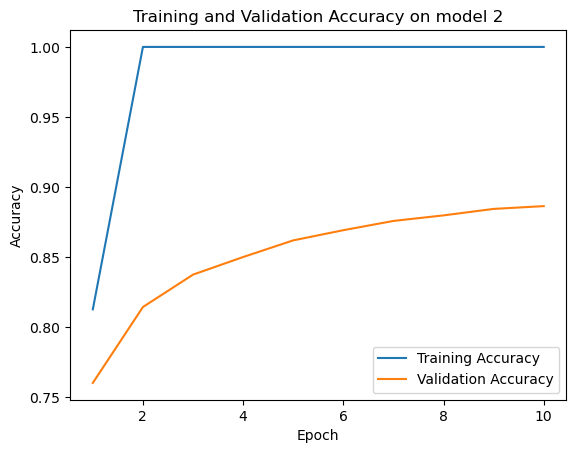

In [22]:
x = np.arange(1, 11)
trainAcc_numpy = torch.stack(trainAcc_).cpu().tolist()
valAcc_numpy = torch.stack(valAcc_,dim=0).cpu().tolist()

plt.plot(x, trainAcc_numpy, label='Training Accuracy')
plt.plot(x, valAcc_numpy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy on model 2')
plt.legend()
plt.show()

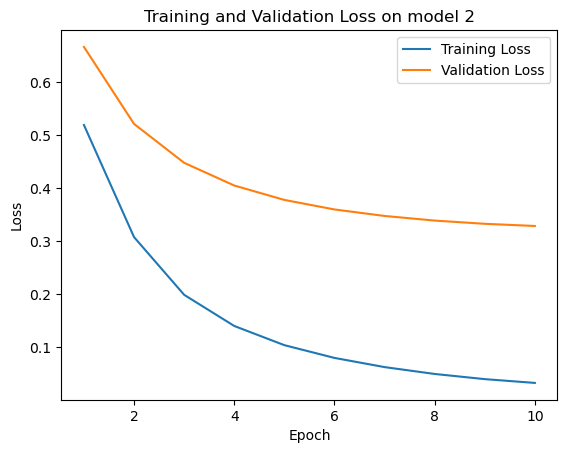

In [23]:
plt.plot(x, trainLoss_, label='Training Loss')
plt.plot(x, valLoss_, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss on model 2')
plt.legend()
plt.show()

# Confusion Matrix for model 2

In [24]:
# Confusion Matrix
predictions_ = []
label_ = []

# turn off gradients for validation
with torch.no_grad():
    for data in valLoader2:
        inputs, labels = data['image'].float(), data['label']
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model2(inputs)
        _, prediction = torch.max(outputs, 1)
        predictions_.extend(prediction.cpu().numpy())
        label_.extend(labels.cpu().numpy())
# compute the confusion matrix on all predictions and labels
confusion_matrix2 = confusion_matrix(label_,predictions_)

E0327 09:20:15.493457516  188040 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 09:20:15.608552561  188040 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


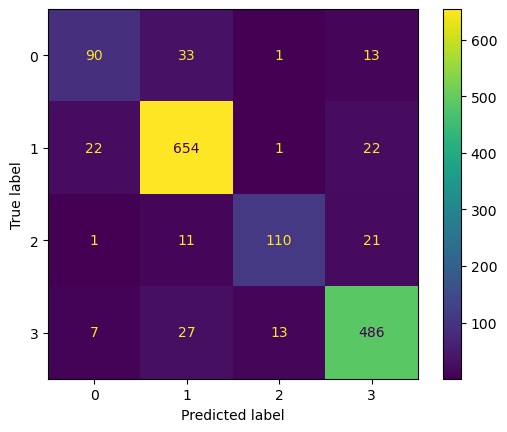

In [25]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix2).plot()

# Making test data predictions using model 2

In [31]:
testLoader2 = DataLoader(test_dataset, batch_size=32,shuffle=False, num_workers=2)
preds_ = []
image_ = []
for data in testLoader2:
    inputs = data['image'].float().to(device)
    image_.extend(data['Filename'])
    # get the model predictions
    with torch.no_grad():
        outputs = model2(inputs)
        
    _, predicted = torch.max(outputs, dim=1)
    
    # append the predicted labels to the list
    preds_.extend(predicted.cpu().numpy().tolist())
    
data2 = {"Filename": image_, "Label": preds_}
df2 = pd.DataFrame(data2)
df2.to_csv("/kaggle/working/submission.csv",  index=False)

E0327 09:51:02.897408748  188040 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 09:51:02.991882477  188040 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


# Using Captum on some images in our dataset using model 1 and model 2

In [33]:
import random

data_folder = "/kaggle/input/deep-learning-for-msc-2022-23/train"
image_paths = [os.path.join(data_folder, filename) for filename in os.listdir(data_folder)]

# Get a random selection of 5 image paths
random_image_paths = random.sample(image_paths, 5)

# Load the images
images = [Image.open(path) for path in random_image_paths]

# For model 2

In [50]:
model2.eval()

t = transforms.Compose([
    transforms.Resize((100,100)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

inputs = torch.stack([t(img) for img in images])

# Access the module attribute of model2 and select the layer for interpretation
layer_act = LayerActivation(model2.module.backbone, model2.module.backbone.layer4)

# Apply the interpretation method to the images using the model
attribution = layer_act.attribute(inputs)

# Visualize the attribution scores as heatmaps
visualization.visualize_image_attr(
    attribution[0],
    method="heat_map",
    cmap="inferno",
    sign="positive",
    outlier_perc=1,
)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor